## Load libraries

In [1]:
# tensorflow backend
print('tensorflow backend')
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
print('vae stuff')
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
print('iport scientific py')
import numpy as np
import pandas as pd
# rdkit stuff
print('rdkit stuff')
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
print('plotting stuff')
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import numpy as np 

import pandas as pd

tensorflow backend
vae stuff


Using TensorFlow backend.
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packag

iport scientific py
rdkit stuff
plotting stuff


In [3]:
vae = VAEUtils(directory='models/zinc_properties')

From C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1210: calling reduce_prod (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\keras\models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
From C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1192: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
From C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1156: calling reduce_max (from tensorflow.python.ops.mat

Using standarized functions? True
Standarization: estimating mu and std values ...done!


## Load smiles

In [2]:
smiles_group = []
df = pd.read_csv('./data/mao/mao_smiles.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
smiles_group = df.values.tolist()

df = pd.read_csv('./data/mao/asinex_smiles.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
smiles_group.extend(df[:4000].values.tolist())
print('molcule fetched :', len(smiles_group))

molcule fetched : 5182


## Convert SMILES to fingerprint

In [10]:
# bytes to bits
def access_bit(data, num):
    base = int(num // 8)
    shift = int(num % 8)
    return (data[base] & (1<<shift)) >> shift

def smiles_to_fp(smiles_group):
    smiles_list = [ mu.canon_smiles(data[0]) for data in smiles_group ]
    mols = [ Chem.MolFromSmiles(smiles) for smiles in smiles_list ]
    
    # rdk fp
    print('\r(2/5) encoding rdk fp...')
    fps = [ Chem.RDKFingerprint(mol) for mol in mols ]
    fpBits = [ [ int(char) for char in fp.ToBitString() ] for fp in fps ]
    rdk_fp_group.extend(list(zip(fpBits, [ data[1] for data in smiles_group ])))

    # pattern fp
    print('\r(3/5) encoding pattern fp...')
    fps = [ Chem.PatternFingerprint(mol) for mol in mols ]
    fpBits = [ [ int(char) for char in fp.ToBitString() ] for fp in fps ]
    pattern_fp_group.extend(list(zip(fpBits, [ data[1] for data in smiles_group ])))

    # layered fp
    print('\r(4/5) encoding layered fp...')
    fps = [ Chem.LayeredFingerprint(mol) for mol in mols ]
    fpBits = [ [ int(char) for char in fp.ToBitString() ] for fp in fps ]
    layered_fp_group.extend(list(zip(fpBits, [ data[1] for data in smiles_group ])))

    # MACCSKeys fp
    print('\r(5/5) encoding layered fp...')
    fps = [ Chem.GetMACCSKeysFingerprint(mol) for mol in mols ]
    fpBits = [ [ int(char) for char in fp.ToBitString() ] for fp in fps ]
    MACCSKeys_fp_group.extend(list(zip(fpBits, [ data[1] for data in smiles_group ])))

In [11]:
rdk_fp_group = []
pattern_fp_group = []
layered_fp_group = []
MACCSKeys_fp_group = []
smiles_to_fp(smiles_group)

(2/5) encoding rdk fp...
(3/5) encoding pattern fp...
(4/5) encoding layered fp...
(5/5) encoding layered fp...


In [16]:
df = pd.DataFrame(rdk_fp_group)
df.to_csv('./data/mao/batched_rdk_fp_group.csv')

df = pd.DataFrame(pattern_fp_group)
df.to_csv('./data/mao/batched_pattern_fp_group.csv')

df = pd.DataFrame(layered_fp_group)
df.to_csv('./data/mao/batched_layered_fp_group.csv')

df = pd.DataFrame(MACCSKeys_fp_group)
df.to_csv('./data/mao/batched_MACCKeys_fp_group.csv')

## Load latent data

In [4]:
print('fetching latent space group...')
latent_group = []
df = pd.read_csv('./data/mao/latent_group.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
for i in range(5000):
    points = list(map(float, df.loc[i, '0'].strip('[]').split(', ')))
    latent_group.append([points, df.loc[i, '1']])
print('# of fetched data:', len(latent_group))

fetching latent space group...
# of fetched data: 5000


## Build DimReduction Model

In [17]:
n_components = 2
model_pca = PCA(n_components=n_components)
model_tsne = TSNE(n_components=n_components)

## Train and Save DimReduction Model

In [19]:
print('\r(1/2) {:30s}'.format('training latent pca...'))
points_latent_pca = model_pca.fit_transform([ points[0] for points in latent_group ])
df = pd.DataFrame(points_latent_pca)
df.to_csv('./data/mao/batched_points_latent_pca.csv')

print('\r(2/2) {:30s}'.format('training latent tsne...'))
points_latent_tsne = model_tsne.fit_transform([ points[0] for points in latent_group ])
df = pd.DataFrame(points_latent_tsne)
df.to_csv('./data/mao/batched_points_latent_tsne.csv')

print('\r(3/10) {:30s}'.format('training rdk fingerprint tsne...'))
points_rdk_fp_tsne = model_tsne.fit_transform([ points[0] for points in rdk_fp_group ])
df = pd.DataFrame(points_rdk_fp_tsne)
df.to_csv('./data/mao/batched_points_rdk_fp_tsne.csv')


print('\r(4/10) {:30s}'.format('training rdk fingerprint pca...'))
points_rdk_fp_pca = model_pca.fit_transform([ points[0] for points in rdk_fp_group ])
df = pd.DataFrame(points_rdk_fp_pca)
df.to_csv('./data/mao/batched_points_rdk_fp_pca.csv')

print('\r(5/10) {:30s}'.format('training pattern fingerprint tsne...'))
points_pattern_fp_tsne = model_tsne.fit_transform([ points[0] for points in pattern_fp_group ])
df = pd.DataFrame(points_pattern_fp_tsne)
df.to_csv('./data/mao/batched_points_pattern_fp_tsne.csv')

print('\r(6/10) {:30s}'.format('training pattern fingerprint pca...'))
points_pattern_fp_pca = model_pca.fit_transform([ points[0] for points in pattern_fp_group ])
df = pd.DataFrame(points_pattern_fp_pca)
df.to_csv('./data/mao/batched_points_pattern_fp_pca.csv')

print('\r(7/10) {:30s}'.format('training layered fingerprint tsne...'))
points_layered_fp_tsne = model_tsne.fit_transform([ points[0] for points in layered_fp_group ])
df = pd.DataFrame(points_layered_fp_tsne)
df.to_csv('./data/mao/batched_points_layered_fp_tsne.csv')

print('\r(8/10) {:30s}'.format('training layered fingerprint pca...'))
points_layered_fp_pca = model_pca.fit_transform([ points[0] for points in layered_fp_group ])
df = pd.DataFrame(points_layered_fp_pca)
df.to_csv('./data/mao/batched_points_layered_fp_pca.csv')

print('\r(9/10) {:30s}'.format('training MACCSKeys fingerprint tsne...'))
points_MACCSKeys_fp_tsne = model_tsne.fit_transform([ points[0] for points in MACCSKeys_fp_group ])
df = pd.DataFrame(points_MACCSKeys_fp_tsne)
df.to_csv('./data/mao/batched_points_MACCSKeys_fp_tsne.csv')

print('\r(10/10) {:30s}'.format('training MACCSKeys fingerprint pca...'))
points_MACCSKeys_fp_pca = model_pca.fit_transform([ points[0] for points in MACCSKeys_fp_group ])
df = pd.DataFrame(points_MACCSKeys_fp_pca)
df.to_csv('./data/mao/batched_points_MACCSKeys_fp_pca.csv')

(7/10) training layered fingerprint tsne...
(8/10) training layered fingerprint pca...
(9/10) training MACCSKeys fingerprint tsne...
(10/10) training MACCSKeys fingerprint pca...


## Load coordinates

In [20]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [23]:
print('(0/10) fetching latent space group...')
latent_target_group = []
df = pd.read_csv('./data/mao/latent_group.csv')
latent_target_group = df['1'].values.tolist()[:5182]
print('data fetched:', len(latent_target_group))

print('(1/10) fetching latent space tsne points...')
points_latent_tsne = []
df = pd.read_csv('./data/mao/batched_points_latent_tsne.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
points_latent_tsne = df.values.tolist()
print('data fetched:', len(points_latent_tsne))

print('(2/10) fetching latent space pca points...')
points_latent_pca = []
df = pd.read_csv('./data/mao/batched_points_latent_pca.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
points_latent_pca = df.values.tolist()
print('data fetched:', len(points_latent_pca))

print('(3/10) fetching rdk fp tsne points...')
points_rdk_fp_tsne = []
df = pd.read_csv('./data/mao/batched_points_rdk_fp_tsne.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
points_rdk_fp_tsne = df.values.tolist()
print('data fetched:', len(points_rdk_fp_tsne))

print('(4/10) fetching rdk fp pca points...')
points_rdk_fp_pca = []
df = pd.read_csv('./data/mao/batched_points_rdk_fp_pca.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
points_rdk_fp_pca = df.values.tolist()
print('data fetched:', len(points_rdk_fp_pca))

print('(5/10) fetching pattern fp tsne points...')
points_pattern_fp_tsne = []
df = pd.read_csv('./data/mao/batched_points_pattern_fp_tsne.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
points_pattern_fp_tsne = df.values.tolist()
print('data fetched:', len(points_pattern_fp_tsne))

print('(6/10) fetching pattern fp pca points...')
points_pattern_fp_pca = []
df = pd.read_csv('./data/mao/batched_points_pattern_fp_pca.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
points_pattern_fp_pca = df.values.tolist()
print('data fetched:', len(points_pattern_fp_pca))

print('(7/10) fetching layered fp tsne points...')
points_layered_fp_tsne = []
df = pd.read_csv('./data/mao/batched_points_layered_fp_tsne.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
points_layered_fp_tsne = df.values.tolist()
print('data fetched:', len(points_layered_fp_tsne))

print('(8/10) fetching layered fp pca points...')
points_layered_fp_pca = []
df = pd.read_csv('./data/mao/batched_points_layered_fp_pca.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
points_layered_fp_pca = df.values.tolist()
print('data fetched:', len(points_layered_fp_pca))

print('(9/10) fetching MACCSKeys fp tsne points...')
points_MACCSKeys_fp_tsne = []
df = pd.read_csv('./data/mao/batched_points_MACCSKeys_fp_tsne.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
points_MACCSKeys_fp_tsne = df.values.tolist()
print('data fetched:', len(points_MACCSKeys_fp_tsne))

print('(10/10) fetching MACCSKeys fp pca points...')
points_MACCSKeys_fp_pca = []
df = pd.read_csv('./data/mao/batched_points_MACCSKeys_fp_pca.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
points_MACCSKeys_fp_pca = df.values.tolist()
print('data fetched:', len(points_MACCSKeys_fp_pca))

# sort loaded data
# sorted = list(zip(latent_target_group, points_latent_pca, points_latent_tsne))
# sorted.sort(key=lambda x:x[0])
# latent_target_group = list(np.array(sorted, dtype=object).T[0])
# points_latent_pca = list(np.array(sorted, dtype=object).T[1])
# points_latent_tsne = list(np.array(sorted, dtype=object).T[2])

(0/10) fetching latent space group...
data fetched: 5182
(1/10) fetching latent space tsne points...
data fetched: 5000
(2/10) fetching latent space pca points...
data fetched: 5000
(3/10) fetching rdk fp tsne points...
data fetched: 5182
(4/10) fetching rdk fp pca points...
data fetched: 5182
(5/10) fetching pattern fp tsne points...
data fetched: 5182
(6/10) fetching pattern fp pca points...
data fetched: 5182
(7/10) fetching layered fp tsne points...
data fetched: 5182
(8/10) fetching layered fp pca points...
data fetched: 5182
(9/10) fetching MACCSKeys fp tsne points...
data fetched: 5182
(10/10) fetching MACCSKeys fp pca points...
data fetched: 5182


In [26]:
# sort loaded data
ltg = latent_target_group
sorted = list(zip(latent_target_group, points_latent_pca, points_latent_tsne))
sorted.sort(key=lambda x:x[0])
latent_target_group = list(np.array(sorted, dtype=object).T[0])
points_latent_pca = list(np.array(sorted, dtype=object).T[1])
points_latent_tsne = list(np.array(sorted, dtype=object).T[2])

sorted = list(zip(ltg, 
    points_rdk_fp_pca, points_rdk_fp_tsne, 
    points_layered_fp_pca, points_layered_fp_tsne, 
    points_pattern_fp_pca, points_pattern_fp_tsne, 
    points_MACCSKeys_fp_pca, points_MACCSKeys_fp_tsne))
sorted.sort(key=lambda x:x[0])
points_rdk_fp_pca = list(np.array(sorted, dtype=object).T[1])
points_rdk_fp_tsne = list(np.array(sorted, dtype=object).T[2])
points_layered_fp_pca = list(np.array(sorted, dtype=object).T[3])
points_layered_fp_tsne = list(np.array(sorted, dtype=object).T[4])
points_pattern_fp_pca = list(np.array(sorted, dtype=object).T[5])
points_pattern_fp_tsne = list(np.array(sorted, dtype=object).T[6])
points_MACCSKeys_fp_pca = list(np.array(sorted, dtype=object).T[7])
points_MACCSKeys_fp_tsne = list(np.array(sorted, dtype=object).T[8])

## Visualize the data

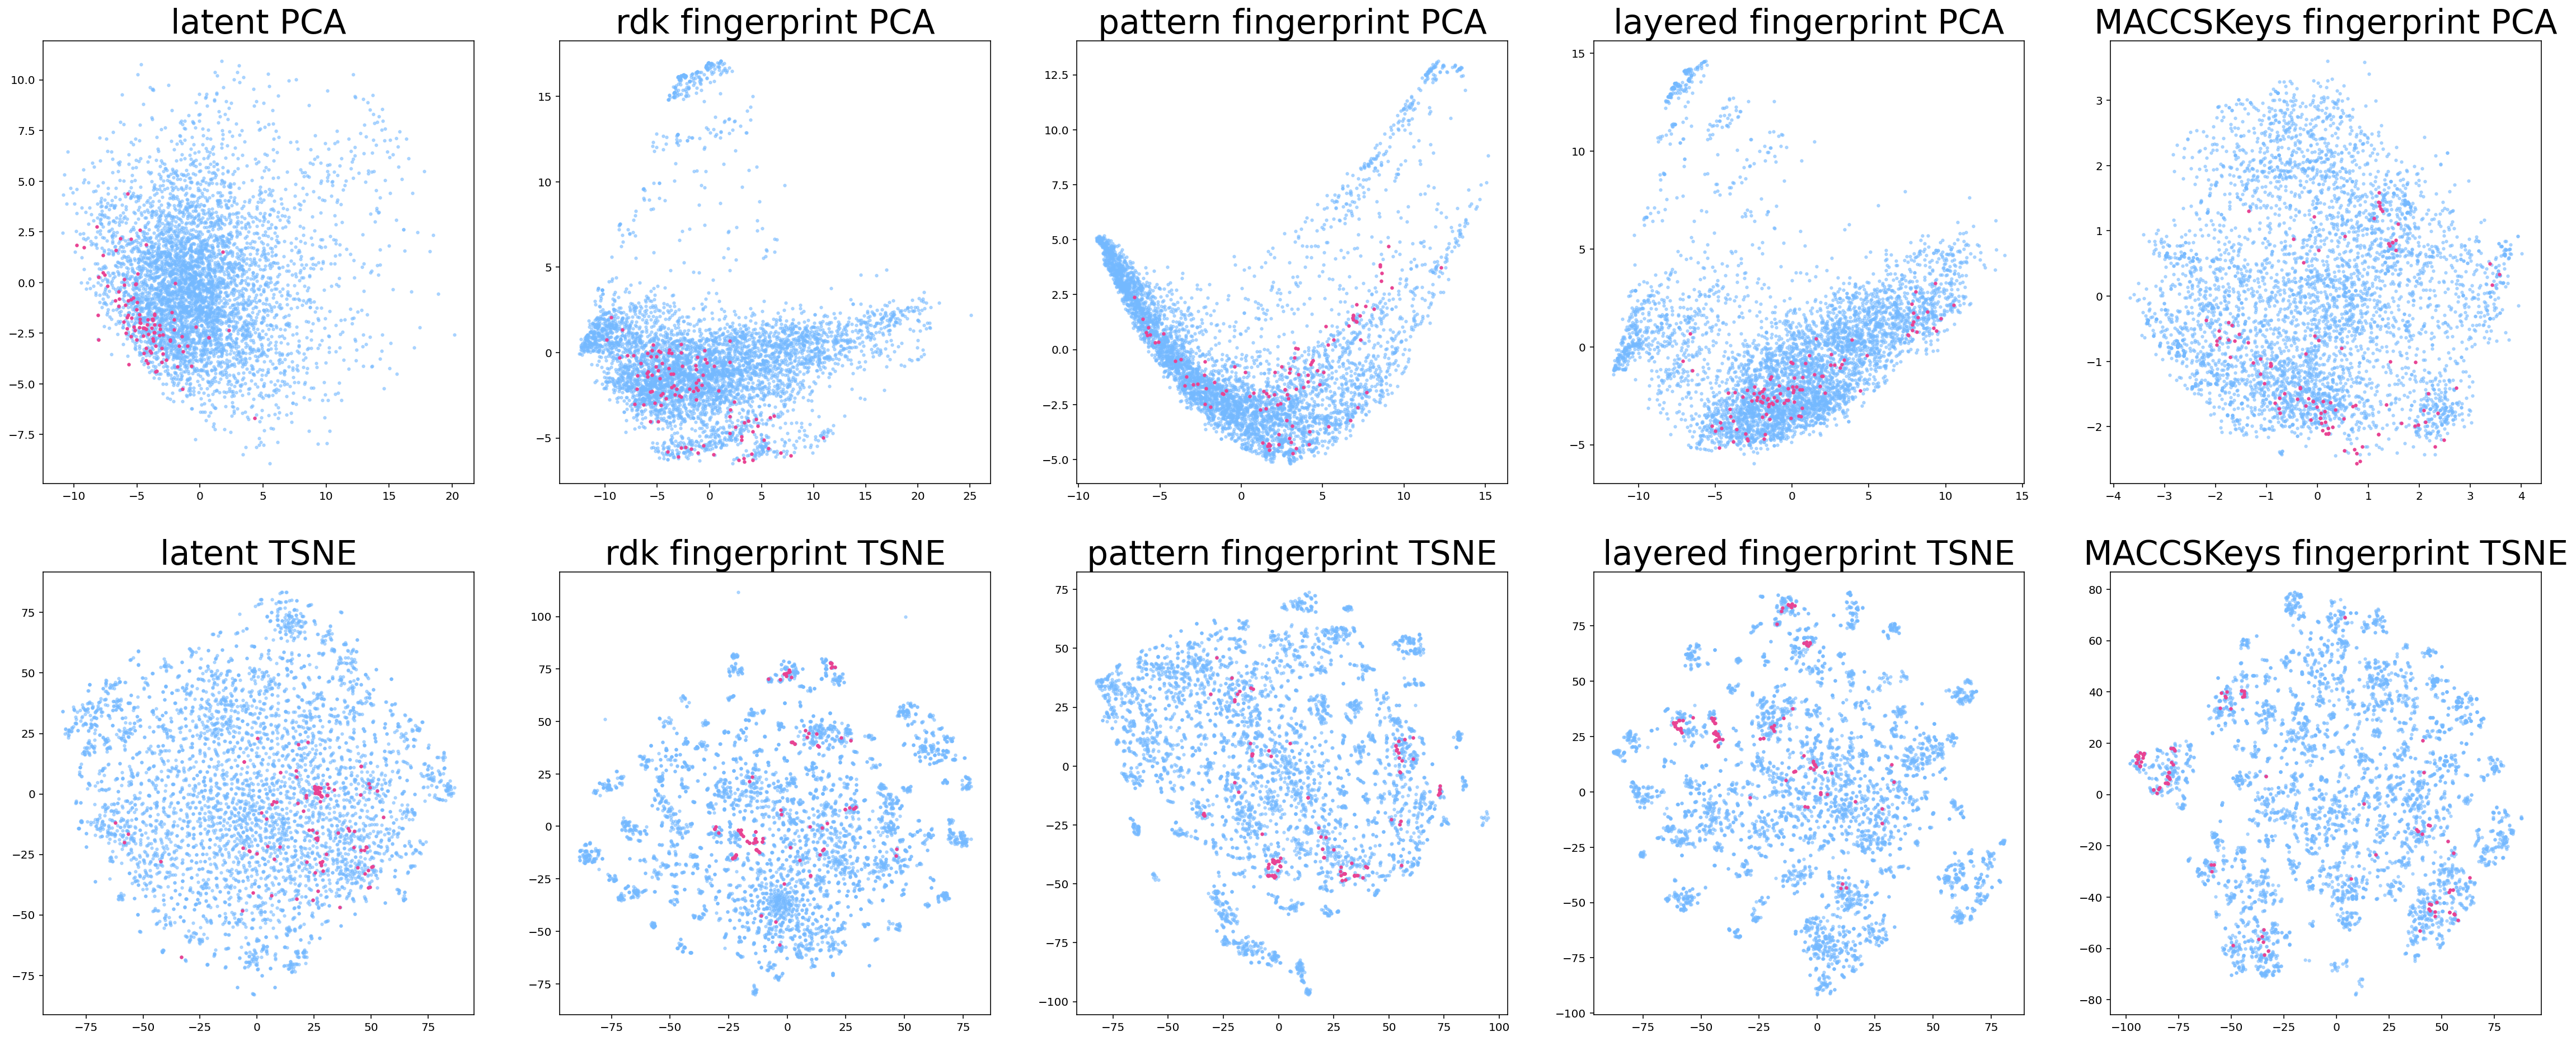

In [37]:
x1 = [ point[0] for point in points_latent_pca ]
y1 = [ point[1] for point in points_latent_pca ]

x2 = [ point[0] for point in points_latent_tsne ]
y2 = [ point[1] for point in points_latent_tsne ]

x3 = [ point[0] for point in points_rdk_fp_pca ]
y3 = [ point[1] for point in points_rdk_fp_pca ]

x4 = [ point[0] for point in points_rdk_fp_tsne ]
y4 = [ point[1] for point in points_rdk_fp_tsne ]

x5 = [ point[0] for point in points_pattern_fp_pca ]
y5 = [ point[1] for point in points_pattern_fp_pca ]

x6 = [ point[0] for point in points_pattern_fp_tsne ]
y6 = [ point[1] for point in points_pattern_fp_tsne ]

x7 = [ point[0] for point in points_layered_fp_pca ]
y7 = [ point[1] for point in points_layered_fp_pca ]

x8 = [ point[0] for point in points_layered_fp_tsne ]
y8 = [ point[1] for point in points_layered_fp_tsne ]

x9 = [ point[0] for point in points_MACCSKeys_fp_pca ]
y9 = [ point[1] for point in points_MACCSKeys_fp_pca ]

x10 = [ point[0] for point in points_MACCSKeys_fp_tsne ]
y10 = [ point[1] for point in points_MACCSKeys_fp_tsne ]

count = 0
for t in latent_target_group[::-1]:
    if t == 1:
        count += 1
    else:
        break

alpha1 = 1.0 
alpha0 = 0.5
size1 = 5
size0 = 5
color1 = '#e84393'
color0 = '#74b9ff'
bg_color = '#ffffff' # '#CAD3C8'
fontsize = 30

cmap = plt.cm.get_cmap('cool', 2)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches((40, 16))
plt.rcParams['axes.facecolor'] = bg_color

plt.subplot(251)
plt.scatter(x1[:-count], y1[:-count], c=color0, s=size0, alpha=alpha0)
plt.scatter(x1[-count:], y1[-count:], c=color1, s=size1, alpha=alpha1)
plt.title('latent PCA', fontsize=fontsize)

plt.subplot(256)
plt.scatter(x2[:-count], y2[:-count], c=color0, s=size0, alpha=alpha0)
plt.scatter(x2[-count:], y2[-count:], c=color1, s=size1, alpha=alpha1)
plt.title('latent TSNE', fontsize=fontsize)

plt.subplot(252)
plt.scatter(x3[:-count], y3[:-count], c=color0, s=size0, alpha=alpha0)
plt.scatter(x3[-count:], y3[-count:], c=color1, s=size1, alpha=alpha1)
plt.title('rdk fingerprint PCA', fontsize=fontsize)

plt.subplot(257)
plt.scatter(x4[:-count], y4[:-count], c=color0, s=size0, alpha=alpha0)
plt.scatter(x4[-count:], y4[-count:], c=color1, s=size1, alpha=alpha1)
plt.title('rdk fingerprint TSNE', fontsize=fontsize)

plt.subplot(253)
plt.scatter(x5[:-count], y5[:-count], c=color0, s=size0, alpha=alpha0)
plt.scatter(x5[-count:], y5[-count:], c=color1, s=size1, alpha=alpha1)
plt.title('pattern fingerprint PCA', fontsize=fontsize)

plt.subplot(258)
plt.scatter(x6[:-count], y6[:-count], c=color0, s=size0, alpha=alpha0)
plt.scatter(x6[-count:], y6[-count:], c=color1, s=size1, alpha=alpha1)
plt.title('pattern fingerprint TSNE', fontsize=fontsize)

plt.subplot(254)
plt.scatter(x7[:-count], y7[:-count], c=color0, s=size0, alpha=alpha0)
plt.scatter(x7[-count:], y7[-count:], c=color1, s=size1, alpha=alpha1)
plt.title('layered fingerprint PCA', fontsize=fontsize)

plt.subplot(259)
plt.scatter(x8[:-count], y8[:-count], c=color0, s=size0, alpha=alpha0)
plt.scatter(x8[-count:], y8[-count:], c=color1, s=size1, alpha=alpha1)
plt.title('layered fingerprint TSNE', fontsize=fontsize)

plt.subplot(255)
plt.scatter(x9[:-count], y9[:-count], c=color0, s=size0, alpha=alpha0)
plt.scatter(x9[-count:], y9[-count:], c=color1, s=size1, alpha=alpha1)
plt.title('MACCSKeys fingerprint PCA', fontsize=fontsize)

plt.subplot(2, 5, 10)
plt.scatter(x10[:-count], y10[:-count], c=color0, s=size0, alpha=alpha0)
plt.scatter(x10[-count:], y10[-count:], c=color1, s=size1, alpha=alpha1)
plt.title('MACCSKeys fingerprint TSNE', fontsize=fontsize)


plt.show()